## Stock Price Prediction with Sentiment Analysis

In [1]:
# # %%time
# !pip install pandas
# !pip install numpy
# !pip install yfinance
# !pip install torch
# !pip install transformers
# !pip install tqdm
# !pip install scikit-learn
# !pip install tensorflow
# !pip install statsmodels
# !pip install matplotlib
# !pip install keras-tuner
# !pip install pandas-datareader
# !pip install pandas_ta
# !pip install charset-normalizer

In [2]:
%%time
# To reload the imported modules automatically
%load_ext autoreload
%autoreload 2

CPU times: user 4.5 ms, sys: 38 μs, total: 4.54 ms
Wall time: 4.75 ms


In [3]:
%%time
# Import the necessary libraries and modules
import os
import warnings
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from statsmodels.tsa.stattools import adfuller

# Import modules
import config as cfg
import data_processing as dp
import sentiment_analysis as sa
import model as mdl
import utils as ut
import time
import keras_tuner as kt
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas_datareader.data as web

2025-08-04 22:13:36.082096: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-04 22:13:36.091465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754345616.103213   49323 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754345616.106593   49323 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754345616.115223   49323 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

CPU times: user 4.39 s, sys: 304 ms, total: 4.7 s
Wall time: 4.67 s


In [4]:
%%time
start_time = time.time()
warnings.filterwarnings("ignore")
np.random.seed(42)
tf.random.set_seed(42)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.makedirs(cfg.DATASET_DIR, exist_ok=True)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /tmp/pycharm_project_408
CPU times: user 381 μs, sys: 27 μs, total: 408 μs
Wall time: 408 μs


In [5]:
%%time
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        # Set memory growth to be the same for all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.list_logical_devices("GPU")
        print(
            f"✅ {len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs configured with memory growth."
        )

    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(f"Error setting memory growth: {e}")
else:
    print("🤷 No GPU detected. TensorFlow will run on CPU.")

✅ 1 Physical GPUs, 1 Logical GPUs configured with memory growth.
CPU times: user 29.7 ms, sys: 115 ms, total: 145 ms
Wall time: 346 ms


I0000 00:00:1754345621.057941   49323 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44389 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:01:00.0, compute capability: 8.9


### Load and Analyze News Data

In [6]:
%%time
sentiment_csv_path = f"{cfg.DATASET_DIR}/{cfg.STOCK_SYMBOL}_daily_sentiment.csv"

if cfg.UPDATE_SENTIMENT_CSV or not os.path.exists(sentiment_csv_path):
    print("Generating new sentiment data and saving to CSV...")
    news_df = dp.load_and_analyze_news_data(cfg.NEWS_DATA_FILE, cfg.STOCK_SYMBOL)
    company_sentiment_df = sa.process_news_sentiment(news_df, cfg.STOCK_SYMBOL)
    daily_sentiment_df = sa.aggregate_daily_sentiment(company_sentiment_df)
    ut.save_dataframe(daily_sentiment_df, sentiment_csv_path)
else:
    print(f"Loading existing sentiment data from {sentiment_csv_path}...")
    daily_sentiment_df = pd.read_csv(
        sentiment_csv_path, index_col="Date", parse_dates=True
    )

print("Sentiment data ready.")

Generating new sentiment data and saving to CSV...
Loading and selecting news data...
File path: Dataset/news_data.csv
Loaded 1400469 articles from Dataset/news_data.csv
🎯 Selected target stock: NVDA (3133 articles)
\n📰 Processing news sentiment for NVDA...
Initializing sentiment analyzer with model: ProsusAI/finbert
Using device: cuda
Analyzer initialized successfully.
Analyzing 3133 headlines in batches of 32...


  0%|          | 0/98 [00:00<?, ?it/s]

\nSentiment distribution:\n Sentiment
neutral     1573
positive     887
negative     673
Name: count, dtype: int64

📊 Aggregating daily sentiment scores...
DataFrame saved to Dataset/NVDA_daily_sentiment.csv
Sentiment data ready.
CPU times: user 6.69 s, sys: 469 ms, total: 7.16 s
Wall time: 8.97 s


In [7]:
print(daily_sentiment_df.head())

            Avg_Sentiment  Total_Sentiment  Positive_Count  Negative_Count  \
Date                                                                         
2011-03-03        -0.8100          -0.8100               0               1   
2011-03-07         0.0390           0.0781               0               0   
2011-03-08         0.0371           0.1485               2               1   
2011-03-09         0.0426           0.1279               0               0   
2011-03-10         0.0289           0.0578               0               0   

            Neutral_Count  News_Count  
Date                                   
2011-03-03              0           1  
2011-03-07              2           2  
2011-03-08              1           4  
2011-03-09              3           3  
2011-03-10              2           2  


### Fetch Stock Data and Calculate Technical Indicators

In [8]:
%%time

START_DATE, END_DATE = ut.calculate_dynamic_date_range(daily_sentiment_df)
print(f"Dynamic date range calculated: {START_DATE} to {END_DATE}")

if cfg.LOAD_LOCAL_STOCK_FILE:
    print(f"Attempting to load local stock data from: {cfg.LOCAL_STOCK_FILE_PATH}...")
    local_file_path = cfg.LOCAL_STOCK_FILE_PATH
    if os.path.exists(local_file_path):
        stock_data = pd.read_csv(local_file_path, index_col="Date", parse_dates=True)
        stock_data.index = stock_data.index.tz_localize(None)
        print(f"✅ Successfully loaded local file: {local_file_path}")

        print("Filtering local data to match the dynamic date range...")
        stock_data = stock_data.loc[START_DATE:END_DATE]
        print("✅ Filtering complete.")

        if cfg.RESAMPLE_DATA:
            print(f"Resampling data to '{cfg.RESAMPLE_FREQUENCY}' frequency...")
            # Define how to aggregate the OHLCV columns
            agg_dict = {
                'Open': 'first',
                'High': 'max',
                'Low': 'min',
                'Close': 'last',
                'Volume': 'sum'
            }
            stock_data = stock_data.resample(cfg.RESAMPLE_FREQUENCY).agg(agg_dict)
            # Drop any rows that are empty after resampling (e.g., weekends/holidays for daily data)
            stock_data.dropna(inplace=True)
            print("✅ Resampling complete.")

    else:
        print(f"⚠️ ERROR: Local file not found at '{local_file_path}'. Please check the path in config.py.")
        stock_data = None

else:

    stock_filename = f"{cfg.STOCK_SYMBOL}_stock_data_{START_DATE}_to_{END_DATE}.csv"
    stock_csv_path = os.path.join(cfg.DATASET_DIR, stock_filename)

    if cfg.UPDATE_STOCK_CSV or not os.path.exists(stock_csv_path):
        print(f"Fetching new stock data from yfinance ({START_DATE} to {END_DATE})...")
        stock_data = dp.fetch_stock_data(cfg.STOCK_SYMBOL, START_DATE, END_DATE)
        if stock_data is not None:
            stock_data.to_csv(stock_csv_path)
            print(f"Stock data saved to {stock_csv_path}")
    else:
        print(f"Loading existing stock data from {stock_csv_path}...")
        stock_data = pd.read_csv(stock_csv_path, index_col="Date", parse_dates=True)
        stock_data.index = stock_data.index.tz_localize("UTC")

if stock_data is not None:
    if stock_data.index.tz is None:
        # If index is naive (from CSV), localize it to UTC
        print("Localizing naive index to UTC...")
        stock_data.index = stock_data.index.tz_localize("UTC")
    else:
        # If index is already aware, convert it to UTC
        print("Converting timezone-aware index to UTC...")
        stock_data.index = stock_data.index.tz_convert("UTC")
else:
    exit()

Dynamic date range calculated: 2010-03-03 to 2020-06-10
Attempting to load local stock data from: Dataset/NVDA_stock_data.csv...
✅ Successfully loaded local file: Dataset/NVDA_stock_data.csv
Filtering local data to match the dynamic date range...
✅ Filtering complete.
Resampling data to '1H' frequency...
✅ Resampling complete.
Localizing naive index to UTC...
CPU times: user 764 ms, sys: 75.1 ms, total: 839 ms
Wall time: 1.58 s


In [9]:
print(stock_data.head())

                             Open    High     Low   Close    Volume
Date                                                               
2010-03-03 09:00:00+00:00  0.3884  0.3904  0.3872  0.3893  38033600
2010-03-03 10:00:00+00:00  0.3895  0.3902  0.3861  0.3879  82324560
2010-03-03 11:00:00+00:00  0.3882  0.3886  0.3870  0.3884  34799720
2010-03-03 12:00:00+00:00  0.3883  0.3886  0.3840  0.3843  28126080
2010-03-03 13:00:00+00:00  0.3844  0.3856  0.3843  0.3846  29674480


In [10]:
# Group by the date part of the index and count the number of entries for each day
data_points_per_day = stock_data.groupby(stock_data.index.date).size()

print("--- Data Points Per Day ---")
print(f"Most common number of data points in a day: {data_points_per_day.mode()[0]}")
print(f"Average number of data points per day: {data_points_per_day.mean():.2f}")
print("\\nBreakdown for the first 5 trading days:")
print(data_points_per_day.head())

--- Data Points Per Day ---
Most common number of data points in a day: 16
Average number of data points per day: 12.65
\nBreakdown for the first 5 trading days:
2010-03-03    10
2010-03-04    12
2010-03-05    12
2010-03-08    12
2010-03-09    13
dtype: int64


#### Add Return Column (Percentage Change)

In [11]:
%%time
# Calculate daily returns, which will be our new target variable
print("--- Calculating Daily Returns ---")
stock_data["Returns"] = stock_data["Close"].pct_change()
tech_data = stock_data.dropna()  # Drop the first row which will have a NaN return
print("'Returns' column created.")

--- Calculating Daily Returns ---
'Returns' column created.
CPU times: user 1.82 ms, sys: 153 μs, total: 1.98 ms
Wall time: 1.96 ms


### Prepare data for the Baseline model

In [12]:
%%time
# Prepare data for the Baseline model
X_train_base, X_test_base, y_train_base, y_test_base, scaler_base = (
    mdl.prepare_data_for_lstm(
        tech_data,
        cfg.BASELINE_FEATURES,
        cfg.BASELINE_TARGET,
        cfg.SEQUENCE_LENGTH,
        cfg.TEST_SIZE,
    )
)

# --- Calculate and print the date ranges ---

# Find the index where the data was split
split_idx = int(len(tech_data) * (1 - cfg.TEST_SIZE))

# The training set dates start after the initial sequence length
train_start_date = tech_data.index[cfg.SEQUENCE_LENGTH]
train_end_date = tech_data.index[split_idx - 1]

# The test set starts right after the training set ends
test_start_date = tech_data.index[split_idx]
test_end_date = tech_data.index[-1]


print(
    f"Baseline data shapes: X_train={X_train_base.shape}, y_train={y_train_base.shape}, X_test={X_test_base.shape}, y_test={y_test_base.shape}"
)

print(f"Train data datetime: {train_start_date.strftime('%Y-%m-%d')} to {train_end_date.strftime('%Y-%m-%d')}")
print(f"Test data datetime:  {test_start_date.strftime('%Y-%m-%d')} to {test_end_date.strftime('%Y-%m-%d')}")

Baseline data shapes: X_train=(29412, 30, 2), y_train=(29412,), X_test=(3272, 30, 2), y_test=(3272,)
Train data datetime: 2010-03-05 to 2019-08-12
Test data datetime:  2019-08-13 to 2020-06-10
CPU times: user 16.2 ms, sys: 4.39 ms, total: 20.6 ms
Wall time: 49 ms


#### Macroeconomic Data from FRED

In [13]:
%%time
if stock_data is not None:
    print("\n--- Fetching and Merging Macroeconomic Data ---")

    # Define the FRED series codes and their new column names
    fred_series = {
        "CPIAUCSL": "Inflation_CPI",
        "FEDFUNDS": "Interest_Rate",
        "UNRATE": "Unemployment_Rate",
    }

    # Fetch the data from FRED
    macro_data = web.DataReader(list(fred_series.keys()), "fred", START_DATE, END_DATE)
    macro_data = macro_data.rename(columns=fred_series)

    stock_data.index = stock_data.index.tz_localize(None)

    # Forward-fill the macroeconomic data, as it's released monthly and is assumed
    # to be constant until the next release period.
    macro_data_daily = macro_data.reindex(stock_data.index, method="ffill")

    # Merge the data
    stock_data = stock_data.join(macro_data_daily)

    # Fill any NaNs at the beginning
    stock_data.bfill(inplace=True)
    print("Macroeconomic features merged successfully.")


--- Fetching and Merging Macroeconomic Data ---
Macroeconomic features merged successfully.
CPU times: user 15.2 ms, sys: 0 ns, total: 15.2 ms
Wall time: 451 ms


In [14]:
# Calculate technical indicators from the loaded/fetched data
tech_data = dp.calculate_technical_indicators(stock_data)
print("Technical indicators calculated.")

Technical indicators calculated.


#### VIX (Volatility Index) Data

In [15]:
## Add VIX (Volatility Index) Data
print("--- Applying Final Fix: Normalizing Dates ---")
try:
    # 1. Standardize tech_data index to UTC
    if tech_data.index.tz is None:
        tech_data.index = tech_data.index.tz_localize("UTC")
    else:
        tech_data.index = tech_data.index.tz_convert("UTC")

    # 2. Standardize VIX data index to UTC
    vix_data = yf.Ticker("^VIX").history(start=START_DATE, end=END_DATE)
    vix_data.index = vix_data.index.tz_convert("UTC")

    # --- NEW FIX: NORMALIZE BOTH INDEXES TO MIDNIGHT ---
    print("\nNormalizing indexes to match on date alone...")
    tech_data.index = tech_data.index.normalize()
    vix_data.index = vix_data.index.normalize()
    print(f"-> Normalized tech_data index starts: {tech_data.index[0]}")
    print(f"-> Normalized VIX index starts:    {vix_data.index[0]}")

    # 3. Perform the join on the normalized indexes
    print("\nJoining dataframes...")
    vix_close = vix_data[["Close"]].rename(columns={"Close": "VIX_Close"})
    tech_data = tech_data.join(vix_close)

    # 4. Check the result
    nan_count = tech_data["VIX_Close"].isna().sum()
    total_count = len(tech_data)
    print(
        f"\nAfter join, VIX_Close has {nan_count} NaN values out of {total_count} rows."
    )

    if nan_count == total_count:
        print("-> WARNING: Join still resulted in all NaN values.")
    else:
        print("-> SUCCESS: Join completed with matching dates.")

    # Fill any remaining NaNs (from non-trading days)
    tech_data.ffill(inplace=True)
    tech_data.bfill(inplace=True)

    print("\n--- VIX Feature Added Successfully ---")

except Exception as e:
    print(f"\n--- AN ERROR OCCURRED ---")
    import traceback

    traceback.print_exc()

--- Applying Final Fix: Normalizing Dates ---

Normalizing indexes to match on date alone...
-> Normalized tech_data index starts: 2010-03-26 00:00:00+00:00
-> Normalized VIX index starts:    2010-03-03 00:00:00+00:00

Joining dataframes...

After join, VIX_Close has 16 NaN values out of 32516 rows.
-> SUCCESS: Join completed with matching dates.

--- VIX Feature Added Successfully ---


In [16]:
%%time
print("--- Checking for Stationarity of the 'Returns' ---")

adf_result = adfuller(tech_data["Returns"])

print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

if adf_result[1] > 0.05:
    print(
        "Result: The 'Returns' price series is likely non-stationary (p-value > 0.05)"
    )
else:
    print("Result: The 'Returns' price series is likely stationary (p-value <= 0.05)")

--- Checking for Stationarity of the 'Returns' ---
ADF Statistic: -46.53193724676423
p-value: 0.0
Result: The 'Returns' price series is likely stationary (p-value <= 0.05)
CPU times: user 4min 38s, sys: 163 ms, total: 4min 38s
Wall time: 1min 18s


In [17]:
ut.save_dataframe(
    tech_data, f"{cfg.OUTPUT_DIR}/" + cfg.STOCK_SYMBOL + "_technical_indicators.csv"
)

DataFrame saved to Output/NVDA_technical_indicators.csv


### Prepare Data for LSTM & SVM Models

In [18]:
%%time
# Prepare data for models using only technical indicators
X_train_tech, X_test_tech, y_train_tech, y_test_tech, scaler_tech = (
    mdl.prepare_data_for_lstm(
        tech_data,
        cfg.TECHNICAL_FEATURES,
        cfg.TECHNICAL_TARGET,
        cfg.SEQUENCE_LENGTH,
        cfg.TEST_SIZE,
    )
)

# Prepare data for models using sentiment + technical indicators
enhanced_full_data = dp.create_enhanced_dataset(tech_data, daily_sentiment_df)
X_train_enh, X_test_enh, y_train_enh, y_test_enh, scaler_enh = (
    mdl.prepare_data_for_lstm(
        enhanced_full_data,
        cfg.HYBRID_FEATURES,
        cfg.HYBRID_TARGET,
        cfg.SEQUENCE_LENGTH,
        cfg.TEST_SIZE,
    )
)


🔗 Merging sentiment and technical data...
Enhanced dataset shape: (32516, 40)
CPU times: user 70.1 ms, sys: 40 ms, total: 110 ms
Wall time: 208 ms


### Single Layer Baseline LSTM Model

In [19]:
%%time
print("\n--- Tuning Baseline Single-Layer LSTM Model ---")

# Define the input shape from your baseline training data
input_shape_base = (X_train_base.shape[1], X_train_base.shape[2])

# Instantiate the tuner for the baseline model
tuner_baseline_lstm = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_single_layer_lstm(hp, input_shape=input_shape_base),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="baseline_single_layer_lstm",  # Use a new project name
    overwrite=False,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the baseline data
print("Starting hyperparameter search for the baseline model...")
tuner_baseline_lstm.search(
    X_train_base,
    y_train_base,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\nBaseline hyperparameter search complete.")

# Get the optimal hyperparameters and the best model for the baseline
best_hps_baseline_lstm = tuner_baseline_lstm.get_best_hyperparameters(num_trials=1)[0]
baseline_lstm_model = tuner_baseline_lstm.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Baseline Single-Layer LSTM:
Units: {best_hps_baseline_lstm.get('units')}
Dropout: {best_hps_baseline_lstm.get('dropout'):.2f}
Learning Rate: {best_hps_baseline_lstm.get('learning_rate')}
---
"""
)


--- Tuning Baseline Single-Layer LSTM Model ---
Reloading Tuner from tuner_results/baseline_single_layer_lstm/tuner0.json
Starting hyperparameter search for the baseline model...

Baseline hyperparameter search complete.

---
Optimal Hyperparameters for Baseline Single-Layer LSTM:
Units: 32
Dropout: 0.30
Learning Rate: 0.001
---

CPU times: user 849 ms, sys: 36.3 ms, total: 885 ms
Wall time: 1.88 s



--- Evaluating Tuned Baseline LSTM Model ---


I0000 00:00:1754345724.207746   49370 cuda_dnn.cc:529] Loaded cuDNN version 90501


{'Model': 'Baseline LSTM', 'RMSE': np.float64(0.009270021262941753), 'MAE': 0.005151094247052876, 'MAPE (%)': np.float64(22138.739743788738), 'R-squared': -0.00033652915658399785, 'Directional_Accuracy': np.float64(68.75573219199022), 'MASE': np.float64(0.23008430160848392)}
Plot saved to Output/NVDA_Baseline_LSTM_analysis.png


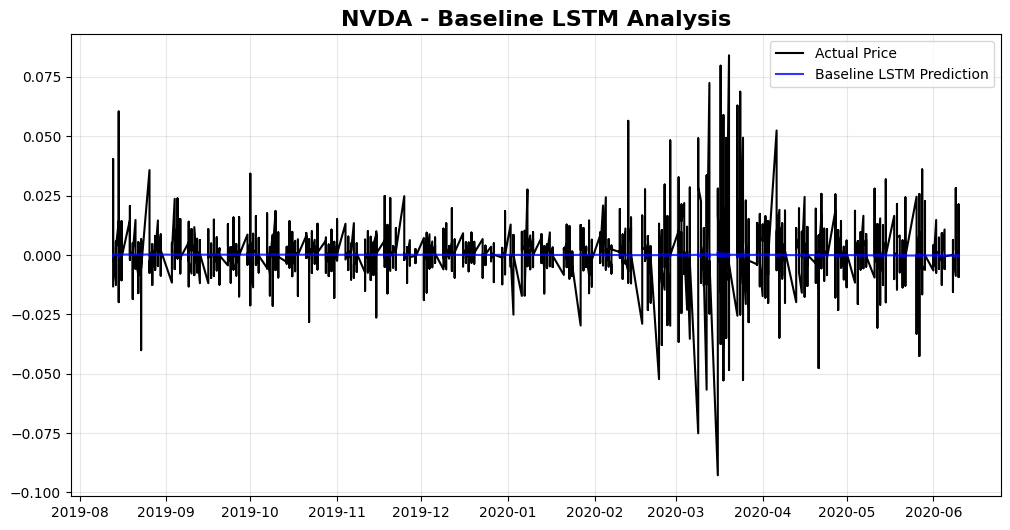

In [20]:
# --- Evaluation ---
print("\n--- Evaluating Tuned Baseline LSTM Model ---")

# Generate predictions on the baseline test set
baseline_preds = baseline_lstm_model.predict(X_test_base, verbose=0)

# --- Correct way to inverse scale the predictions ---
# 1. Create a new scaler for the single target column ('Returns')
target_scaler = MinMaxScaler()

# 2. Fit it ONLY on the 'Returns' column of the TRAINING data
#    We use 'tech_data' as it's the source DataFrame before splitting.
train_data_len = len(tech_data) - len(y_test_base)
target_scaler.fit(tech_data[["Returns"]][:train_data_len])

# 3. Now, inverse transform using the correctly fitted scaler
y_test_base_scaled = target_scaler.inverse_transform(y_test_base.reshape(-1, 1))
baseline_preds_scaled = target_scaler.inverse_transform(baseline_preds)


# Calculate and print the performance metrics
baseline_lstm_metrics = ut.calculate_metrics(
    y_test_base_scaled, baseline_preds_scaled, "Baseline LSTM", y_train_base
)
print(baseline_lstm_metrics)


# Plot the prediction results against the actual values
test_dates_base = tech_data.index[-len(y_test_base_scaled) :]
ut.plot_non_keras_results(
    y_test_base_scaled,
    baseline_preds_scaled,
    test_dates_base,
    cfg.STOCK_SYMBOL,
    "Baseline LSTM",
)

### Single Layer Technical LSTM Model

In [21]:
%%time
print("\n--- Tuning Single-Layer Technical LSTM Model ---")

# Define the input shape from your technical training data
input_shape_tech = (X_train_tech.shape[1], X_train_tech.shape[2])

# Instantiate the tuner for the technical model
tuner_single_lstm_tech = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_single_layer_lstm(hp, input_shape=input_shape_tech),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="technical_single_layer_lstm",  # More descriptive project name
    overwrite=False,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the technical data
print("Starting hyperparameter search for the technical model...")
tuner_single_lstm_tech.search(
    X_train_tech,
    y_train_tech,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\nTechnical model hyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_single_lstm_tech = tuner_single_lstm_tech.get_best_hyperparameters(
    num_trials=1
)[0]
single_lstm_model_tech = tuner_single_lstm_tech.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Single-Layer Technical LSTM:
Units: {best_hps_single_lstm_tech.get('units')}
Dropout: {best_hps_single_lstm_tech.get('dropout'):.2f}
Learning Rate: {best_hps_single_lstm_tech.get('learning_rate')}
---
"""
)


--- Tuning Single-Layer Technical LSTM Model ---
Reloading Tuner from tuner_results/technical_single_layer_lstm/tuner0.json
Starting hyperparameter search for the technical model...

Technical model hyperparameter search complete.

---
Optimal Hyperparameters for Single-Layer Technical LSTM:
Units: 96
Dropout: 0.30
Learning Rate: 0.001
---

CPU times: user 458 ms, sys: 4.07 ms, total: 462 ms
Wall time: 1.01 s



--- Evaluating Best Single-Layer Technical LSTM Model ---
{'Model': 'Single-Layer Technical LSTM', 'RMSE': np.float64(0.009260783012371855), 'MAE': 0.005154114559669526, 'MAPE (%)': np.float64(51434.56551399983), 'R-squared': -3.6684636129935555e-05, 'Directional_Accuracy': np.float64(69.02491541064289), 'MASE': np.float64(0.23015901971868066)}
Plot saved to Output/NVDA_Single-Layer_Technical_LSTM_analysis.png


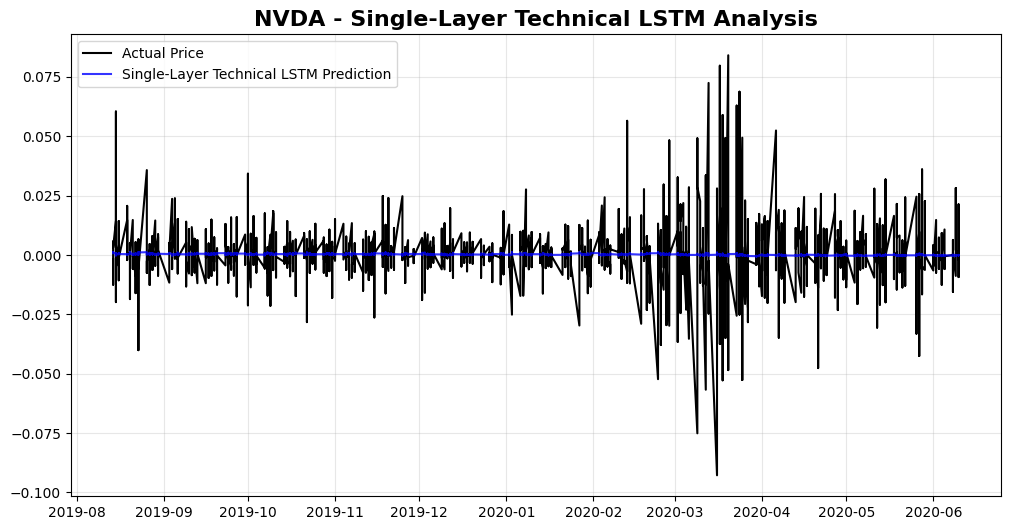

CPU times: user 469 ms, sys: 24 ms, total: 493 ms
Wall time: 743 ms


In [22]:
%%time
# --- Evaluation using the best technical model ---
print("\n--- Evaluating Best Single-Layer Technical LSTM Model ---")

# Generate predictions on the technical test set
single_layer_lstm_preds_tech = single_lstm_model_tech.predict(X_test_tech, verbose=0)

# --- Correct way to inverse scale the predictions ---
# 1. Create a new scaler for the single target column ('Returns')
target_scaler_tech = MinMaxScaler()

# 2. Fit it ONLY on the 'Returns' column of the TRAINING data
train_data_len_tech = len(tech_data) - len(y_test_tech)
target_scaler_tech.fit(tech_data[["Returns"]][:train_data_len_tech])

# 3. Now, inverse transform using the correctly fitted scaler
y_test_tech_scaled = target_scaler_tech.inverse_transform(y_test_tech.reshape(-1, 1))
tech_preds_scaled = target_scaler_tech.inverse_transform(single_layer_lstm_preds_tech)


# Calculate and print metrics for the technical model
tech_metrics = ut.calculate_metrics(
    y_test_tech_scaled, tech_preds_scaled, "Single-Layer Technical LSTM", y_train_tech
)
print(tech_metrics)

# Plot the results
test_dates_tech = tech_data.index[-len(y_test_tech_scaled) :]
ut.plot_non_keras_results(
    y_test_tech_scaled,
    tech_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "Single-Layer Technical LSTM",
)

### Single-Layer Enhanced LSTM Model

In [23]:
%%time
print("\n--- Tuning Single-Layer Hybrid/Enhanced LSTM Model ---")

# Define the input shape from your hybrid/enhanced training data
input_shape_enh = (X_train_enh.shape[1], X_train_enh.shape[2])

# Instantiate the tuner for the hybrid/enhanced model
tuner_single_lstm_enh = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_single_layer_lstm(hp, input_shape=input_shape_enh),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="hybrid_enhanced_single_layer_lstm",  # Made name more specific
    overwrite=False,
)

# Define a callback for early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the hybrid/enhanced data
print("Starting hyperparameter search on hybrid/enhanced data...")
tuner_single_lstm_enh.search(
    X_train_enh,
    y_train_enh,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\nHybrid/Enhanced model hyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_single_lstm_enh = tuner_single_lstm_enh.get_best_hyperparameters(num_trials=1)[
    0
]
single_lstm_model_enh = tuner_single_lstm_enh.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Single-Layer Hybrid/Enhanced LSTM:
Units: {best_hps_single_lstm_enh.get('units')}
Dropout: {best_hps_single_lstm_enh.get('dropout'):.2f}
Learning Rate: {best_hps_single_lstm_enh.get('learning_rate')}
---
"""
)


--- Tuning Single-Layer Hybrid/Enhanced LSTM Model ---
Reloading Tuner from tuner_results/hybrid_enhanced_single_layer_lstm/tuner0.json
Starting hyperparameter search on hybrid/enhanced data...

Hybrid/Enhanced model hyperparameter search complete.

---
Optimal Hyperparameters for Single-Layer Hybrid/Enhanced LSTM:
Units: 192
Dropout: 0.40
Learning Rate: 0.01
---

CPU times: user 483 ms, sys: 112 μs, total: 483 ms
Wall time: 1.03 s



--- Evaluating Best Single-Layer Hybrid/Enhanced LSTM Model ---
{'Model': 'Single-Layer Hybrid LSTM', 'RMSE': np.float64(0.009255964029026172), 'MAE': 0.005151187844919253, 'MAPE (%)': np.float64(25929.489538846603), 'R-squared': 0.0010038118881510183, 'Directional_Accuracy': np.float64(71.73177483851123), 'MASE': np.float64(0.2300283261164876)}
Plot saved to Output/NVDA_Single-Layer_Hybrid_LSTM_analysis.png


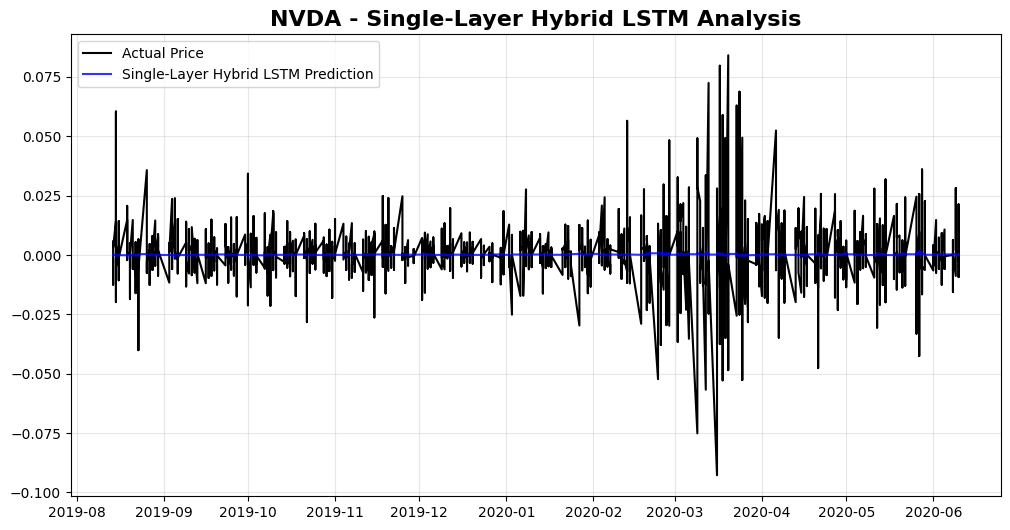

CPU times: user 436 ms, sys: 20.1 ms, total: 456 ms
Wall time: 811 ms


In [24]:
%%time
# --- Evaluation using the best hybrid/enhanced model ---
print("\n--- Evaluating Best Single-Layer Hybrid/Enhanced LSTM Model ---")

# Generate predictions on the hybrid/enhanced test set
single_layer_lstm_preds_enh = single_lstm_model_enh.predict(X_test_enh, verbose=0)

# --- Correct way to inverse scale the predictions ---
# 1. Create a new scaler for the single target column ('Returns')
target_scaler_enh = MinMaxScaler()

# 2. Fit it ONLY on the 'Returns' column of the TRAINING data
train_data_len_enh = len(enhanced_full_data) - len(y_test_enh)
target_scaler_enh.fit(enhanced_full_data[["Returns"]][:train_data_len_enh])

# 3. Now, inverse transform using the correctly fitted scaler
y_test_enh_scaled = target_scaler_enh.inverse_transform(y_test_enh.reshape(-1, 1))
enh_preds_scaled = target_scaler_enh.inverse_transform(single_layer_lstm_preds_enh)

# Calculate and print metrics for the hybrid/enhanced model
enh_metrics = ut.calculate_metrics(
    y_test_enh_scaled, enh_preds_scaled, "Single-Layer Hybrid LSTM", y_train_enh
)
print(enh_metrics)

# Plot the results
test_dates_enh = enhanced_full_data.index[-len(y_test_enh_scaled) :]
ut.plot_non_keras_results(
    y_test_enh_scaled,
    enh_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Single-Layer Hybrid LSTM",
)

##### Compare Single Layer LSTM Model

Plot saved to Output/NVDA_all_models_comparison.png


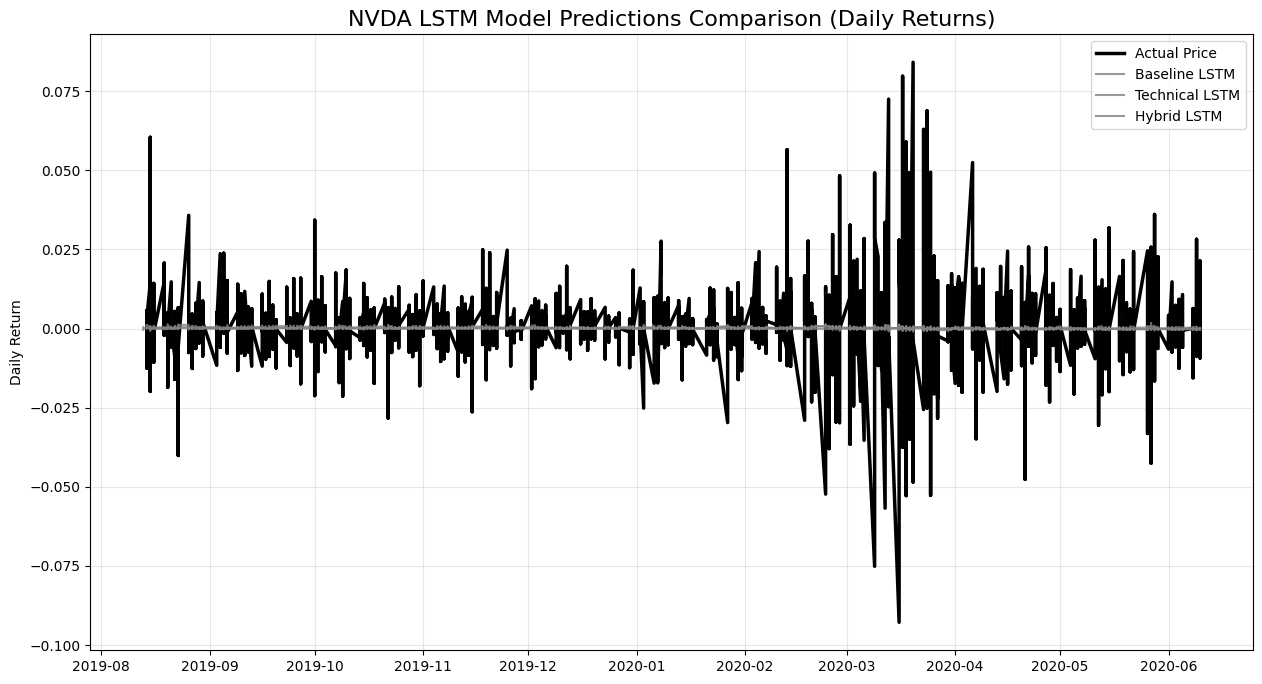

CPU times: user 233 ms, sys: 4.03 ms, total: 237 ms
Wall time: 486 ms


In [25]:
%%time

plot_data = {
    "Actual": {"dates": test_dates_enh, "values": y_test_enh_scaled},
    "Baseline LSTM": {"dates": test_dates_base, "values": baseline_preds_scaled},
    "Technical LSTM": {"dates": test_dates_tech, "values": tech_preds_scaled},
    "Hybrid LSTM": {"dates": test_dates_enh, "values": enh_preds_scaled},
}

ut.plot_final_comparison(
    plot_data,
    cfg.STOCK_SYMBOL,
    f"{cfg.STOCK_SYMBOL} LSTM Model Predictions Comparison (Daily Returns)",
)

### Multi-Layer Baseline LSTM Models

In [26]:
%%time
print("\n--- Tuning Baseline Multi-Layer LSTM Model ---")

# Define the input shape from your baseline training data
input_shape_base = (X_train_base.shape[1], X_train_base.shape[2])

# Instantiate the tuner for the baseline multi-layer model
tuner_multi_lstm_base = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_multi_layer_lstm(hp, input_shape=input_shape_base),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="baseline_multi_layer_lstm",  # New project name
    overwrite=False,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the baseline data
print("Starting hyperparameter search for the baseline multi-layer model...")
tuner_multi_lstm_base.search(
    X_train_base,
    y_train_base,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\nBaseline multi-layer hyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_multi_lstm_base = tuner_multi_lstm_base.get_best_hyperparameters(num_trials=1)[
    0
]
multi_layer_model_base = tuner_multi_lstm_base.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Baseline Multi-Layer LSTM:
Units Layer 1: {best_hps_multi_lstm_base.get('units_1')}
Units Layer 2: {best_hps_multi_lstm_base.get('units_2')}
Dropout: {best_hps_multi_lstm_base.get('dropout'):.2f}
Learning Rate: {best_hps_multi_lstm_base.get('learning_rate')}
---
"""
)


--- Tuning Baseline Multi-Layer LSTM Model ---
Reloading Tuner from tuner_results/baseline_multi_layer_lstm/tuner0.json
Starting hyperparameter search for the baseline multi-layer model...

Baseline multi-layer hyperparameter search complete.

---
Optimal Hyperparameters for Baseline Multi-Layer LSTM:
Units Layer 1: 256
Units Layer 2: 32
Dropout: 0.40
Learning Rate: 0.001
---

CPU times: user 481 ms, sys: 121 μs, total: 481 ms
Wall time: 1.05 s



--- Evaluating Best Baseline Multi-Layer LSTM Model ---
{'Model': 'Multi-Layer Baseline LSTM', 'RMSE': np.float64(0.009275048799150814), 'MAE': 0.005155508713973164, 'MAPE (%)': np.float64(18742.04922050335), 'R-squared': -0.0014218755141806039, 'Directional_Accuracy': np.float64(39.95719963313971), 'MASE': np.float64(0.23028148292367911)}
Plot saved to Output/NVDA_Multi-Layer_Baseline_LSTM_analysis.png


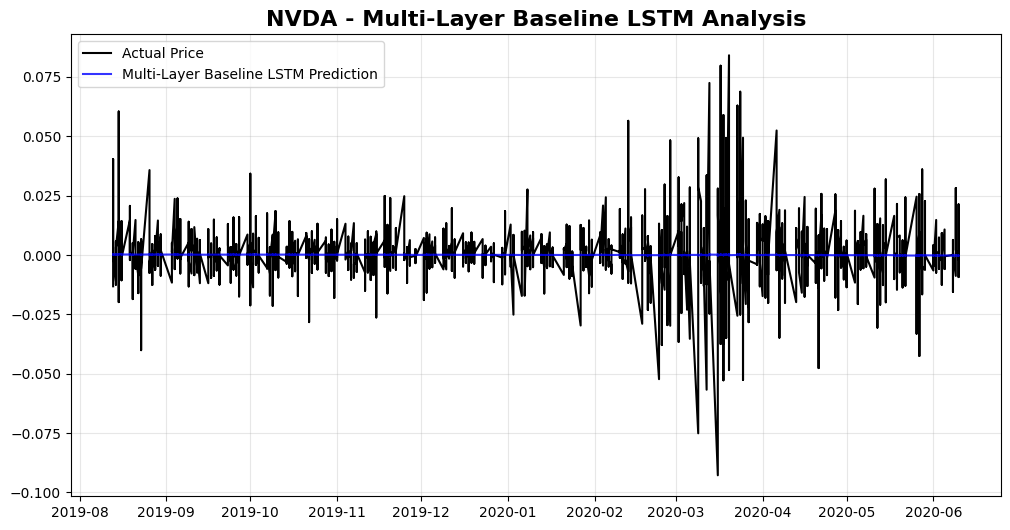

CPU times: user 605 ms, sys: 16 ms, total: 621 ms
Wall time: 1.05 s


In [27]:
%%time
# --- Evaluation using the best baseline multi-layer model ---
print("\n--- Evaluating Best Baseline Multi-Layer LSTM Model ---")

# Generate predictions on the baseline test set
multi_layer_preds_base = multi_layer_model_base.predict(X_test_base, verbose=0)

# --- Correct way to inverse scale the predictions ---
# 1. Create a new scaler for the single target column ('Returns')
target_scaler_base_ml = MinMaxScaler()  # Use a unique name to avoid conflicts

# 2. Fit it ONLY on the 'Returns' column of the TRAINING data
train_data_len_base = len(tech_data) - len(y_test_base)
target_scaler_base_ml.fit(tech_data[["Returns"]][:train_data_len_base])

# 3. Now, inverse transform using the correctly fitted scaler
y_test_base_scaled = target_scaler_base_ml.inverse_transform(y_test_base.reshape(-1, 1))
multi_preds_scaled_base = target_scaler_base_ml.inverse_transform(
    multi_layer_preds_base
)


# Calculate and print metrics
multi_layer_metrics_base = ut.calculate_metrics(
    y_test_base_scaled,
    multi_preds_scaled_base,
    "Multi-Layer Baseline LSTM",
    y_train_base,
)
print(multi_layer_metrics_base)

# Plot the results
test_dates_base = tech_data.index[-len(y_test_base_scaled) :]
ut.plot_non_keras_results(
    y_test_base_scaled,
    multi_preds_scaled_base,
    test_dates_base,
    cfg.STOCK_SYMBOL,
    "Multi-Layer Baseline LSTM",
)

### Multi-Layer Technical LSTM Model

In [28]:
%%time
print("\n--- Tuning Multi-Layer Technical LSTM Model ---")

# Define the input shape from your technical training data
input_shape_tech = (X_train_tech.shape[1], X_train_tech.shape[2])

# Instantiate the tuner for the technical multi-layer model
tuner_multi_lstm_tech = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_multi_layer_lstm(hp, input_shape=input_shape_tech),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="technical_multi_layer_lstm",  # Specific project name
    overwrite=False,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the technical data
print("Starting hyperparameter search for the technical multi-layer model...")
tuner_multi_lstm_tech.search(
    X_train_tech,
    y_train_tech,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\nTechnical multi-layer hyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_multi_lstm_tech = tuner_multi_lstm_tech.get_best_hyperparameters(num_trials=1)[
    0
]
multi_layer_model_tech = tuner_multi_lstm_tech.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Multi-Layer Technical LSTM:
Units Layer 1: {best_hps_multi_lstm_tech.get('units_1')}
Units Layer 2: {best_hps_multi_lstm_tech.get('units_2')}
Dropout: {best_hps_multi_lstm_tech.get('dropout'):.2f}
Learning Rate: {best_hps_multi_lstm_tech.get('learning_rate')}
---
"""
)


--- Tuning Multi-Layer Technical LSTM Model ---
Reloading Tuner from tuner_results/technical_multi_layer_lstm/tuner0.json
Starting hyperparameter search for the technical multi-layer model...

Technical multi-layer hyperparameter search complete.

---
Optimal Hyperparameters for Multi-Layer Technical LSTM:
Units Layer 1: 256
Units Layer 2: 32
Dropout: 0.50
Learning Rate: 0.0001
---

CPU times: user 509 ms, sys: 162 μs, total: 509 ms
Wall time: 1.12 s



--- Evaluating Best Multi-Layer Technical LSTM Model ---
{'Model': 'Multi-Layer Technical LSTM', 'RMSE': np.float64(0.009274350850434269), 'MAE': 0.005153108722278426, 'MAPE (%)': np.float64(24598.425051322974), 'R-squared': -0.0029691094993127276, 'Directional_Accuracy': np.float64(43.21747154721624), 'MASE': np.float64(0.23011410365303026)}
Plot saved to Output/NVDA_Multi-Layer_Technical_LSTM_analysis.png


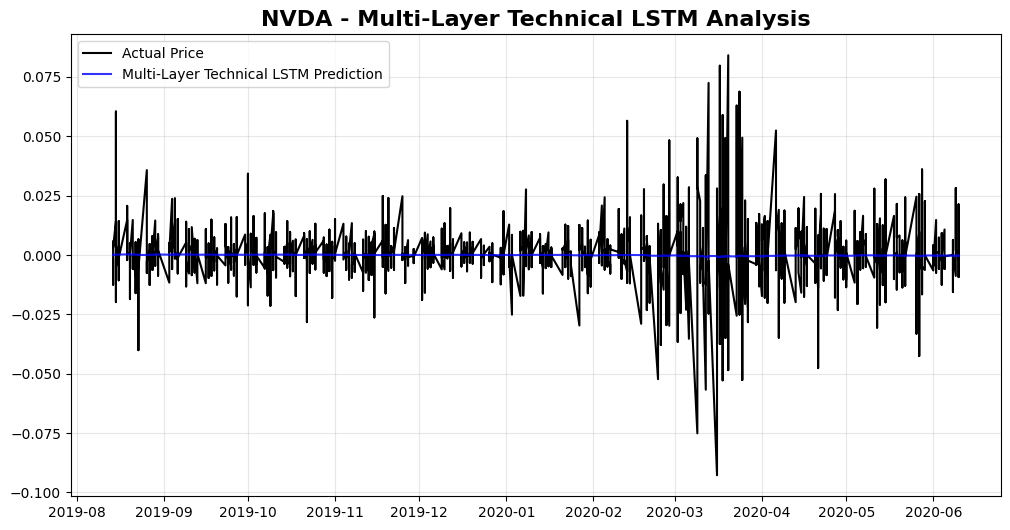

CPU times: user 614 ms, sys: 20.1 ms, total: 634 ms
Wall time: 723 ms


In [29]:
%%time
# --- Evaluation using the best technical multi-layer model ---
print("\n--- Evaluating Best Multi-Layer Technical LSTM Model ---")

# Generate predictions on the technical test set
multi_layer_preds_tech = multi_layer_model_tech.predict(X_test_tech, verbose=0)

# --- Correct way to inverse scale the predictions ---
# 1. Create a new scaler for the single target column ('Returns')
target_scaler_tech_ml = MinMaxScaler()  # Use a unique name

# 2. Fit it ONLY on the 'Returns' column of the TRAINING data
train_data_len_tech = len(tech_data) - len(y_test_tech)
target_scaler_tech_ml.fit(tech_data[["Returns"]][:train_data_len_tech])

# 3. Now, inverse transform using the correctly fitted scaler
y_test_tech_scaled = target_scaler_tech_ml.inverse_transform(y_test_tech.reshape(-1, 1))
multi_preds_scaled_tech = target_scaler_tech_ml.inverse_transform(
    multi_layer_preds_tech
)

# Calculate and print metrics
multi_layer_metrics_tech = ut.calculate_metrics(
    y_test_tech_scaled,
    multi_preds_scaled_tech,
    "Multi-Layer Technical LSTM",
    y_train_tech,
)
print(multi_layer_metrics_tech)

# Plot the results
test_dates_tech = tech_data.index[-len(y_test_tech_scaled) :]
ut.plot_non_keras_results(
    y_test_tech_scaled,
    multi_preds_scaled_tech,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "Multi-Layer Technical LSTM",
)

### Multi-Layer Enhanced LSTM Model

In [30]:
%%time
print("\n--- Tuning Multi-Layer Hybrid/Enhanced LSTM Model ---")

# Define the input shape from your hybrid/enhanced training data
input_shape_enh = (X_train_enh.shape[1], X_train_enh.shape[2])

# Instantiate the tuner for the hybrid/enhanced multi-layer model
tuner_multi_lstm_enh = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_multi_layer_lstm(hp, input_shape=input_shape_enh),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="hybrid_enhanced_multi_layer_lstm",  # Specific project name
    overwrite=False,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the hybrid/enhanced data
print("Starting hyperparameter search for the hybrid/enhanced multi-layer model...")
tuner_multi_lstm_enh.search(
    X_train_enh,
    y_train_enh,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\nHybrid/Enhanced multi-layer hyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_multi_lstm_enh = tuner_multi_lstm_enh.get_best_hyperparameters(num_trials=1)[0]
multi_layer_model_enh = tuner_multi_lstm_enh.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Multi-Layer Hybrid/Enhanced LSTM:
Units Layer 1: {best_hps_multi_lstm_enh.get('units_1')}
Units Layer 2: {best_hps_multi_lstm_enh.get('units_2')}
Dropout: {best_hps_multi_lstm_enh.get('dropout'):.2f}
Learning Rate: {best_hps_multi_lstm_enh.get('learning_rate')}
---
"""
)


--- Tuning Multi-Layer Hybrid/Enhanced LSTM Model ---
Reloading Tuner from tuner_results/hybrid_enhanced_multi_layer_lstm/tuner0.json
Starting hyperparameter search for the hybrid/enhanced multi-layer model...

Hybrid/Enhanced multi-layer hyperparameter search complete.

---
Optimal Hyperparameters for Multi-Layer Hybrid/Enhanced LSTM:
Units Layer 1: 128
Units Layer 2: 128
Dropout: 0.10
Learning Rate: 0.01
---

CPU times: user 501 ms, sys: 107 μs, total: 501 ms
Wall time: 1.18 s



--- Evaluating Best Multi-Layer Hybrid/Enhanced LSTM Model ---
{'Model': 'Multi-Layer Hybrid LSTM', 'RMSE': np.float64(0.009268086992880373), 'MAE': 0.005154987866674025, 'MAPE (%)': np.float64(9973.807968400566), 'R-squared': -0.0016147647775979213, 'Directional_Accuracy': np.float64(57.73608120578284), 'MASE': np.float64(0.23019801758761468)}
Plot saved to Output/NVDA_Multi-Layer_Hybrid_LSTM_analysis.png


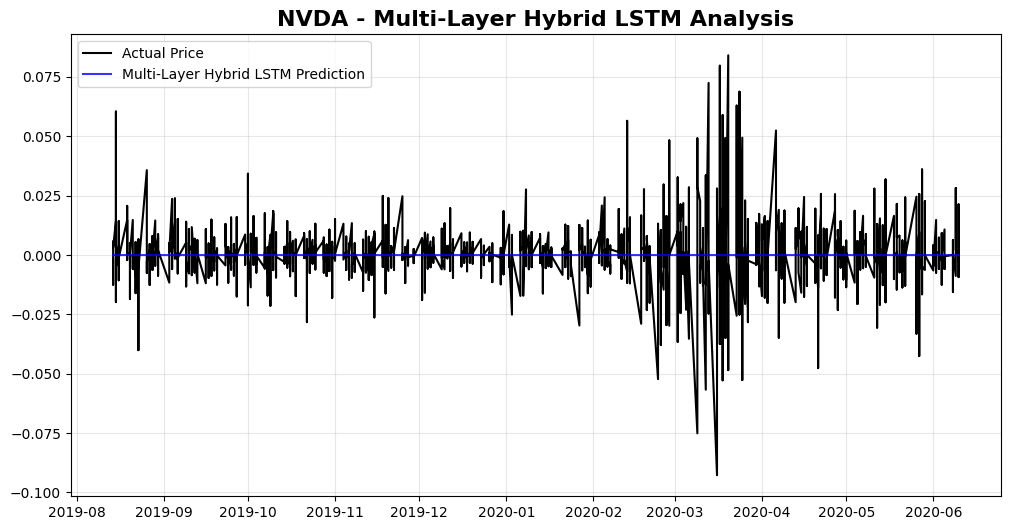

CPU times: user 587 ms, sys: 8.06 ms, total: 595 ms
Wall time: 1.02 s


In [31]:
%%time
# --- Evaluation using the best hybrid/enhanced multi-layer model ---
print("\n--- Evaluating Best Multi-Layer Hybrid/Enhanced LSTM Model ---")

# Generate predictions on the hybrid/enhanced test set
multi_layer_preds_enh = multi_layer_model_enh.predict(X_test_enh, verbose=0)

# --- Correct way to inverse scale the predictions ---
# 1. Create a new scaler for the single target column ('Returns')
target_scaler_enh_ml = MinMaxScaler()  # Use a unique name

# 2. Fit it ONLY on the 'Returns' column of the TRAINING data
train_data_len_enh = len(enhanced_full_data) - len(y_test_enh)
target_scaler_enh_ml.fit(enhanced_full_data[["Returns"]][:train_data_len_enh])

# 3. Now, inverse transform using the correctly fitted scaler
y_test_enh_scaled = target_scaler_enh_ml.inverse_transform(y_test_enh.reshape(-1, 1))
multi_preds_scaled_enh = target_scaler_enh_ml.inverse_transform(multi_layer_preds_enh)

# Calculate and print metrics
multi_layer_metrics_enh = ut.calculate_metrics(
    y_test_enh_scaled, multi_preds_scaled_enh, "Multi-Layer Hybrid LSTM", y_train_enh
)
print(multi_layer_metrics_enh)

# Plot the results
test_dates_enh = enhanced_full_data.index[-len(y_test_enh_scaled) :]
ut.plot_non_keras_results(
    y_test_enh_scaled,
    multi_preds_scaled_enh,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Multi-Layer Hybrid LSTM",
)

### Baseline GRU Model

In [32]:
%%time
print("\n--- Tuning Baseline GRU Model ---")

# Define the input shape from your BASELINE training data
input_shape_base = (X_train_base.shape[1], X_train_base.shape[2])

# Instantiate the tuner for the GRU model
tuner_base_gru = kt.Hyperband(
    # Ensure the model builder uses the correct input shape
    hypermodel=lambda hp: mdl.build_gru(hp, input_shape=input_shape_base),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="baseline_gru",
    overwrite=False,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the BASELINE data
print("Starting GRU hyperparameter search on baseline data...")
tuner_base_gru.search(
    X_train_base,
    y_train_base,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_base_gru = tuner_base_gru.get_best_hyperparameters(num_trials=1)[0]
baseline_gru_model = tuner_base_gru.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Baseline GRU:
Units Layer 1: {best_hps_base_gru.get('units_1')}
Units Layer 2: {best_hps_base_gru.get('units_2')}
Dropout: {best_hps_base_gru.get('dropout'):.2f}
Learning Rate: {best_hps_base_gru.get('learning_rate')}
---
"""
)


--- Tuning Baseline GRU Model ---
Reloading Tuner from tuner_results/baseline_gru/tuner0.json
Starting GRU hyperparameter search on baseline data...

Hyperparameter search complete.

---
Optimal Hyperparameters for Baseline GRU:
Units Layer 1: 256
Units Layer 2: 32
Dropout: 0.10
Learning Rate: 0.001
---

CPU times: user 494 ms, sys: 93 μs, total: 495 ms
Wall time: 1.05 s



--- Evaluating Best Baseline GRU Model ---
{'Model': 'Baseline GRU', 'RMSE': np.float64(0.0503166150485841), 'MAE': 0.04951694213464197, 'MAPE (%)': np.float64(8834923.271268543), 'R-squared': -28.471857034198788, 'Directional_Accuracy': np.float64(63.405686334454295), 'MASE': np.float64(2.211776857966672)}
Plot saved to Output/NVDA_Baseline_GRU_analysis.png


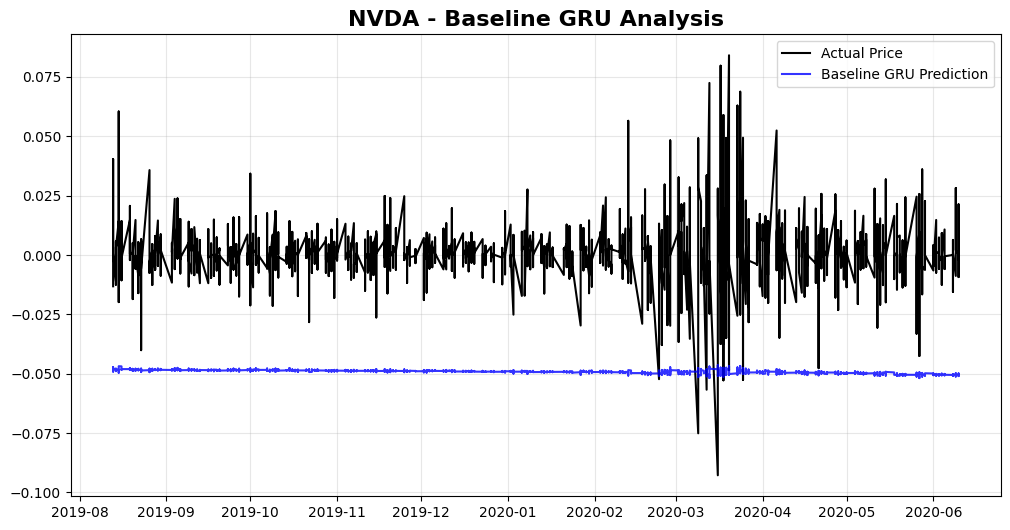

CPU times: user 570 ms, sys: 24.1 ms, total: 595 ms
Wall time: 1 s


In [33]:
%%time
# --- Evaluation using the best baseline GRU model ---
print("\n--- Evaluating Best Baseline GRU Model ---")

# Generate predictions on the BASELINE test set
base_gru_preds = baseline_gru_model.predict(X_test_base, verbose=0)

# --- Correct way to inverse scale the predictions ---
# 1. Create a new scaler for the single target column ('Returns')
target_scaler_base_gru = MinMaxScaler()  # Use a unique name

# 2. Fit it ONLY on the 'Returns' column of the TRAINING data
train_data_len_base = len(tech_data) - len(y_test_base)
target_scaler_base_gru.fit(tech_data[["Returns"]][:train_data_len_base])

# 3. Now, inverse transform using the correctly fitted scaler
y_test_base_scaled = target_scaler_base_gru.inverse_transform(
    y_test_base.reshape(-1, 1)
)
base_gru_preds_scaled = target_scaler_base_gru.inverse_transform(base_gru_preds)


# Calculate and print metrics for the baseline GRU model
baseline_gru_metrics = ut.calculate_metrics(
    y_test_base_scaled, base_gru_preds_scaled, "Baseline GRU", y_train_base
)
print(baseline_gru_metrics)


# Plot the results
test_dates_base = tech_data.index[-len(y_test_base_scaled) :]
ut.plot_non_keras_results(
    y_test_base_scaled,
    base_gru_preds_scaled,
    test_dates_base,
    cfg.STOCK_SYMBOL,
    "Baseline GRU",
)

### Technical GRU Model

In [34]:
%%time
print("\n--- Tuning Technical GRU Model ---")

# Define the input shape from your TECHNICAL training data
input_shape_tech = (X_train_tech.shape[1], X_train_tech.shape[2])

# Instantiate the tuner for the technical GRU model
tuner_tech_gru = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_gru(hp, input_shape=input_shape_tech),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="technical_gru",
    overwrite=False,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the TECHNICAL data
print("Starting GRU hyperparameter search on technical data...")
tuner_tech_gru.search(
    X_train_tech,
    y_train_tech,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_tech_gru = tuner_tech_gru.get_best_hyperparameters(num_trials=1)[0]
technical_gru_model = tuner_tech_gru.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Technical GRU:
Units Layer 1: {best_hps_tech_gru.get('units_1')}
Units Layer 2: {best_hps_tech_gru.get('units_2')}
Dropout: {best_hps_tech_gru.get('dropout'):.2f}
Learning Rate: {best_hps_tech_gru.get('learning_rate')}
---
"""
)


--- Tuning Technical GRU Model ---
Reloading Tuner from tuner_results/technical_gru/tuner0.json
Starting GRU hyperparameter search on technical data...

Hyperparameter search complete.

---
Optimal Hyperparameters for Technical GRU:
Units Layer 1: 64
Units Layer 2: 64
Dropout: 0.20
Learning Rate: 0.01
---

CPU times: user 505 ms, sys: 89 μs, total: 506 ms
Wall time: 1.04 s



--- Evaluating Best Technical GRU Model ---
{'Model': 'Technical GRU', 'RMSE': np.float64(0.05453548657637958), 'MAE': 0.05378518089812226, 'MAPE (%)': np.float64(9669196.237900157), 'R-squared': -33.67998487874222, 'Directional_Accuracy': np.float64(67.0255306059674), 'MASE': np.float64(2.4017984791741727)}
Plot saved to Output/NVDA_Technical_GRU_analysis.png


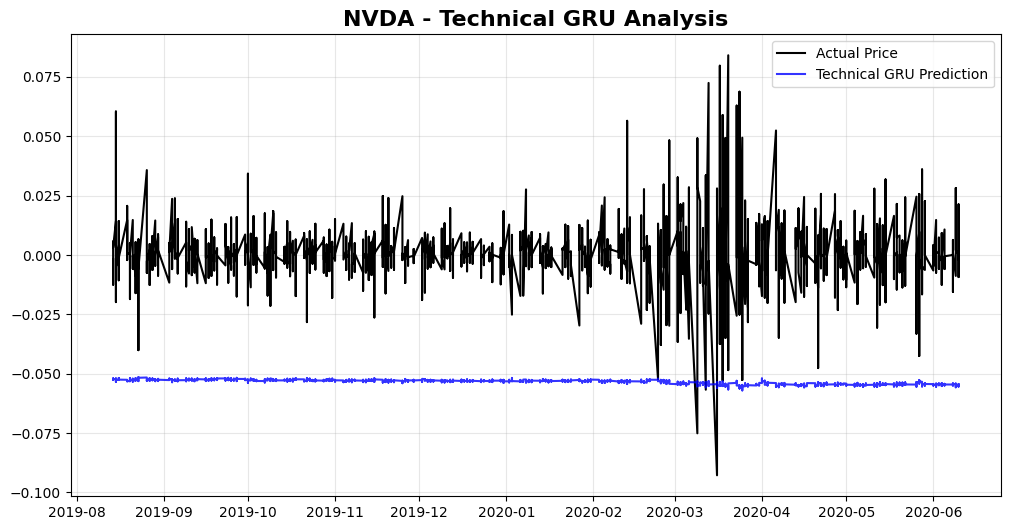

CPU times: user 595 ms, sys: 16.1 ms, total: 611 ms
Wall time: 1.02 s


In [35]:
%%time
# --- Evaluation using the best technical GRU model ---
print("\n--- Evaluating Best Technical GRU Model ---")

# Generate predictions on the TECHNICAL test set
tech_gru_preds = technical_gru_model.predict(X_test_tech, verbose=0)

# --- Correct way to inverse scale the predictions ---
# 1. Create a new scaler for the single target column ('Returns')
target_scaler_tech_gru = MinMaxScaler()  # Use a unique name

# 2. Fit it ONLY on the 'Returns' column of the TRAINING data
train_data_len_tech = len(tech_data) - len(y_test_tech)
target_scaler_tech_gru.fit(tech_data[["Returns"]][:train_data_len_tech])

# 3. Now, inverse transform using the correctly fitted scaler
y_test_tech_scaled = target_scaler_tech_gru.inverse_transform(
    y_test_tech.reshape(-1, 1)
)
tech_gru_preds_scaled = target_scaler_tech_gru.inverse_transform(tech_gru_preds)

# Calculate and print metrics for the technical GRU model
technical_gru_metrics = ut.calculate_metrics(
    y_test_tech_scaled, tech_gru_preds_scaled, "Technical GRU", y_train_tech
)
print(technical_gru_metrics)

# Plot the results
test_dates_tech = tech_data.index[-len(y_test_tech_scaled) :]
ut.plot_non_keras_results(
    y_test_tech_scaled,
    tech_gru_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "Technical GRU",
)

### Enhanced GRU Model

In [36]:
%%time
print("\n--- Tuning Hybrid/Enhanced GRU Model ---")

# Define the input shape from your HYBRID/ENHANCED training data
input_shape_enh = (X_train_enh.shape[1], X_train_enh.shape[2])

# Instantiate the tuner for the hybrid/enhanced GRU model
tuner_enh_gru = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_gru(hp, input_shape=input_shape_enh),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="enhanced_gru",
    overwrite=False,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the HYBRID/ENHANCED data
print("Starting GRU hyperparameter search on enhanced data...")
tuner_enh_gru.search(
    X_train_enh,
    y_train_enh,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_enh_gru = tuner_enh_gru.get_best_hyperparameters(num_trials=1)[0]
enhanced_gru_model = tuner_enh_gru.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Hybrid/Enhanced GRU:
Units Layer 1: {best_hps_enh_gru.get('units_1')}
Units Layer 2: {best_hps_enh_gru.get('units_2')}
Dropout: {best_hps_enh_gru.get('dropout'):.2f}
Learning Rate: {best_hps_enh_gru.get('learning_rate')}
---
"""
)


--- Tuning Hybrid/Enhanced GRU Model ---
Reloading Tuner from tuner_results/enhanced_gru/tuner0.json
Starting GRU hyperparameter search on enhanced data...

Hyperparameter search complete.

---
Optimal Hyperparameters for Hybrid/Enhanced GRU:
Units Layer 1: 64
Units Layer 2: 64
Dropout: 0.10
Learning Rate: 0.01
---

CPU times: user 510 ms, sys: 137 μs, total: 511 ms
Wall time: 1.13 s



--- Evaluating Best Hybrid/Enhanced GRU Model ---
{'Model': 'Enhanced GRU', 'RMSE': np.float64(0.055627501448328655), 'MAE': 0.05489430657955452, 'MAPE (%)': np.float64(9890655.26771173), 'R-squared': -35.08274940526963, 'Directional_Accuracy': np.float64(67.5484466318056), 'MASE': np.float64(2.451326924191823)}
Plot saved to Output/NVDA_Enhanced_GRU_analysis.png


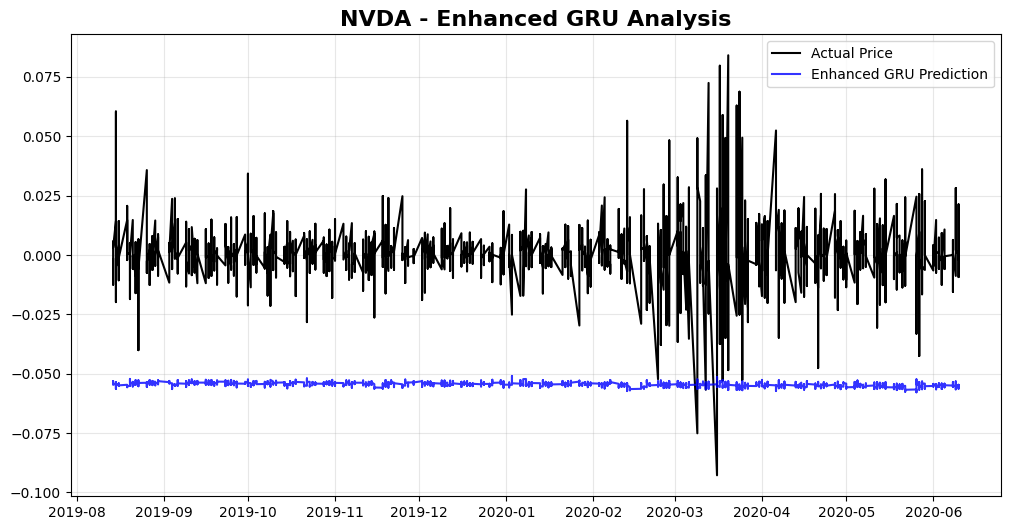

CPU times: user 577 ms, sys: 12.2 ms, total: 589 ms
Wall time: 785 ms


In [37]:
%%time
# --- Evaluation using the best hybrid/enhanced GRU model ---
print("\n--- Evaluating Best Hybrid/Enhanced GRU Model ---")

# Generate predictions on the HYBRID/ENHANCED test set
enh_gru_preds = enhanced_gru_model.predict(X_test_enh, verbose=0)

# --- Correct way to inverse scale the predictions ---
# 1. Create a new scaler for the single target column ('Returns')
target_scaler_enh_gru = MinMaxScaler()  # Use a unique name

# 2. Fit it ONLY on the 'Returns' column of the TRAINING data
train_data_len_enh = len(enhanced_full_data) - len(y_test_enh)
target_scaler_enh_gru.fit(enhanced_full_data[["Returns"]][:train_data_len_enh])

# 3. Now, inverse transform using the correctly fitted scaler
y_test_enh_scaled = target_scaler_enh_gru.inverse_transform(y_test_enh.reshape(-1, 1))
enh_gru_preds_scaled = target_scaler_enh_gru.inverse_transform(enh_gru_preds)

# Calculate and print metrics for the hybrid/enhanced GRU model
enhanced_gru_metrics = ut.calculate_metrics(
    y_test_enh_scaled, enh_gru_preds_scaled, "Enhanced GRU", y_train_enh
)
print(enhanced_gru_metrics)

# Plot the results
test_dates_enh = enhanced_full_data.index[-len(y_test_enh_scaled) :]
ut.plot_non_keras_results(
    y_test_enh_scaled,
    enh_gru_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Enhanced GRU",
)

### Baseline SVM Model

In [38]:
%%time
# --- Preparing Data for Baseline SVM Model ---
print("\n--- Preparing Data for Baseline SVM Model ---")

# SVM requires 2D input, so we flatten the sequence data from the baseline dataset
nsamples, nx, ny = X_train_base.shape
X_train_svm_base = X_train_base.reshape((nsamples, nx * ny))

nsamples, nx, ny = X_test_base.shape
X_test_svm_base = X_test_base.reshape((nsamples, nx * ny))

# We'll use the original y_train and y_test, but we need to flatten y_train for the model's fit method
y_train_svm_base = y_train_base.ravel()
y_test_svm_base = y_test_base.ravel()

print(
    f"Reshaped Baseline data for SVM: X_train={X_train_svm_base.shape}, y_train={y_train_svm_base.shape}"
)


--- Preparing Data for Baseline SVM Model ---
Reshaped Baseline data for SVM: X_train=(29412, 60), y_train=(29412,)
CPU times: user 203 μs, sys: 0 ns, total: 203 μs
Wall time: 12.1 ms



--- Tuning and Training Baseline SVM Model ---
Building and tuning SVM model with GridSearchCV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.4s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.3s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.5s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.5s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.5s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.5s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.5s[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.6s

[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   2.1s
[CV] END ..........C=1, epsilo

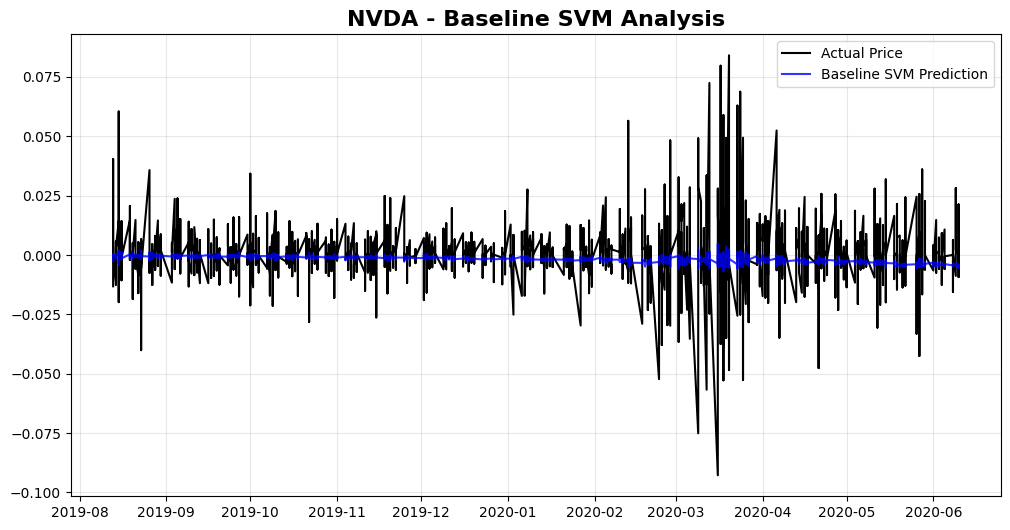

CPU times: user 1.88 s, sys: 104 ms, total: 1.99 s
Wall time: 23.5 s


In [39]:
%%time
# --- Build and train the SVM using the baseline data ---
print("\n--- Tuning and Training Baseline SVM Model ---")
baseline_svm_model = mdl.build_and_train_svm(X_train_svm_base, y_train_svm_base)

# --- Evaluate the best model found ---
print("\n--- Evaluating Best Baseline SVM Model ---")
base_svm_preds = baseline_svm_model.predict(X_test_svm_base)

# --- Correct way to inverse scale the predictions ---
# 1. Create a new scaler for the single target column ('Returns')
target_scaler_svm_base = MinMaxScaler()  # Use a unique name

# 2. Fit it ONLY on the 'Returns' column of the TRAINING data
train_data_len_base = len(tech_data) - len(y_test_base)
target_scaler_svm_base.fit(tech_data[["Returns"]][:train_data_len_base])

# 3. Now, inverse transform using the correctly fitted scaler
y_test_svm_base_scaled = target_scaler_svm_base.inverse_transform(
    y_test_base.reshape(-1, 1)
)
base_svm_preds_scaled = target_scaler_svm_base.inverse_transform(
    base_svm_preds.reshape(-1, 1)
)


# Calculate and print metrics
baseline_svm_metrics = ut.calculate_metrics(
    y_test_svm_base_scaled, base_svm_preds_scaled, "Baseline SVM", y_train_base
)
print(baseline_svm_metrics)


# Plot the results
test_dates_base = tech_data.index[-len(y_test_svm_base_scaled) :]
ut.plot_non_keras_results(
    y_test_svm_base_scaled,
    base_svm_preds_scaled,
    test_dates_base,
    cfg.STOCK_SYMBOL,
    "Baseline SVM",
)

#### Technical SVM Model

In [40]:
%%time
# --- Preparing Data for Technical SVM Model ---
print("\n--- Preparing Data for Technical SVM Model ---")

# SVM requires 2D input, so we flatten the sequence data from the technical dataset
nsamples, nx, ny = X_train_tech.shape
X_train_svm_tech = X_train_tech.reshape((nsamples, nx * ny))

nsamples, nx, ny = X_test_tech.shape
X_test_svm_tech = X_test_tech.reshape((nsamples, nx * ny))

# Flatten the y_train and y_test arrays for the SVM's fit method
y_train_svm_tech = y_train_tech.ravel()
y_test_svm_tech = y_test_tech.ravel()

print(
    f"Reshaped Technical data for SVM: X_train={X_train_svm_tech.shape}, y_train={y_train_svm_tech.shape}"
)


--- Preparing Data for Technical SVM Model ---
Reshaped Technical data for SVM: X_train=(29234, 540), y_train=(29234,)
CPU times: user 205 μs, sys: 1 μs, total: 206 μs
Wall time: 14.7 ms



--- Tuning and Training Technical SVM Model ---
Building and tuning SVM model with GridSearchCV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   2.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   2.4s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   2.6s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   2.9s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   3.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   3.2s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   3.9s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   4.1s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   2.6s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=  11.2s
[CV] END ..........C=1, epsil

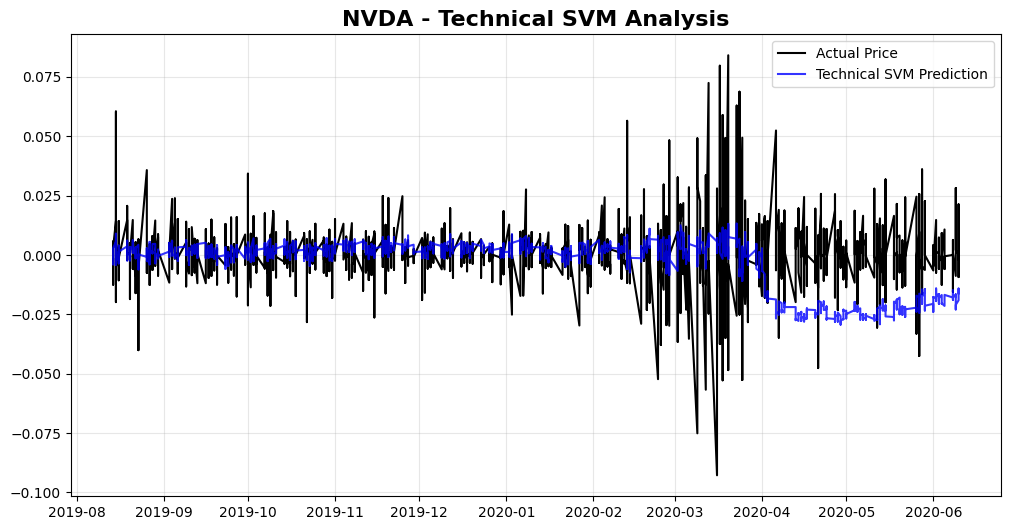

CPU times: user 10.3 s, sys: 124 ms, total: 10.4 s
Wall time: 1min 57s


In [41]:
%%time
# --- Build and train the SVM using the technical data ---
print("\n--- Tuning and Training Technical SVM Model ---")
technical_svm_model = mdl.build_and_train_svm(X_train_svm_tech, y_train_svm_tech)

# --- Evaluate the best model found ---
print("\n--- Evaluating Best Technical SVM Model ---")
tech_svm_preds = technical_svm_model.predict(X_test_svm_tech)

# --- Correct way to inverse scale the predictions ---
# 1. Create a new scaler for the single target column ('Returns')
target_scaler_svm_tech = MinMaxScaler()  # Use a unique name

# 2. Fit it ONLY on the 'Returns' column of the TRAINING data
train_data_len_tech = len(tech_data) - len(y_test_tech)
target_scaler_svm_tech.fit(tech_data[["Returns"]][:train_data_len_tech])

# 3. Now, inverse transform using the correctly fitted scaler
y_test_svm_tech_scaled = target_scaler_svm_tech.inverse_transform(
    y_test_tech.reshape(-1, 1)
)
tech_svm_preds_scaled = target_scaler_svm_tech.inverse_transform(
    tech_svm_preds.reshape(-1, 1)
)


# Calculate and print metrics
technical_svm_metrics = ut.calculate_metrics(
    y_test_svm_tech_scaled, tech_svm_preds_scaled, "Technical SVM", y_train_tech
)
print(technical_svm_metrics)


# Plot the results
test_dates_tech = tech_data.index[-len(y_test_svm_tech_scaled) :]
ut.plot_non_keras_results(
    y_test_svm_tech_scaled,
    tech_svm_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "Technical SVM",
)

### Enhanced SVM Model

In [42]:
%%time
# --- Preparing Data for Hybrid/Enhanced SVM Model ---
print("\n--- Preparing Data for Hybrid/Enhanced SVM Model ---")

# SVM requires 2D input, so we flatten the sequence data from the enhanced dataset
nsamples, nx, ny = X_train_enh.shape
X_train_svm_enh = X_train_enh.reshape((nsamples, nx * ny))

nsamples, nx, ny = X_test_enh.shape
X_test_svm_enh = X_test_enh.reshape((nsamples, nx * ny))

# Flatten the y_train and y_test arrays for the SVM's fit method
y_train_svm_enh = y_train_enh.ravel()
y_test_svm_enh = y_test_enh.ravel()

print(
    f"Reshaped Enhanced data for SVM: X_train={X_train_svm_enh.shape}, y_train={y_train_svm_enh.shape}"
)


--- Preparing Data for Hybrid/Enhanced SVM Model ---
Reshaped Enhanced data for SVM: X_train=(29234, 660), y_train=(29234,)
CPU times: user 508 μs, sys: 3 μs, total: 511 μs
Wall time: 6.24 ms



--- Tuning and Training Hybrid/Enhanced SVM Model ---
Building and tuning SVM model with GridSearchCV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   2.2s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   2.6s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   2.9s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   3.3s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   3.4s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   3.6s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   4.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   4.3s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   3.1s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=  13.0s
[CV] END ..........C=1,

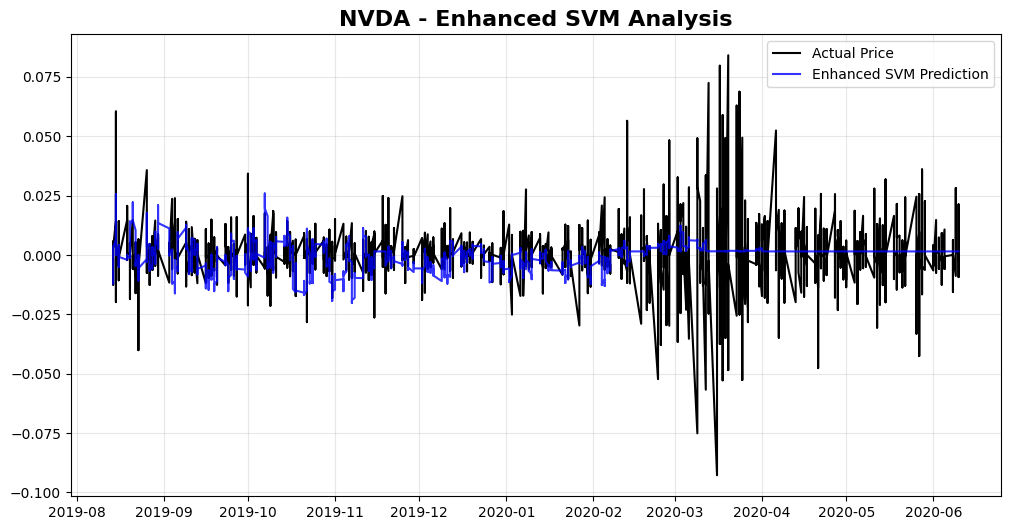

CPU times: user 3.35 s, sys: 116 ms, total: 3.47 s
Wall time: 1min 59s


In [43]:
%%time
# --- Build and train the SVM using the hybrid/enhanced data ---
print("\n--- Tuning and Training Hybrid/Enhanced SVM Model ---")
enhanced_svm_model = mdl.build_and_train_svm(X_train_svm_enh, y_train_svm_enh)

# --- Evaluate the best model found ---
print("\n--- Evaluating Best Hybrid/Enhanced SVM Model ---")
enh_svm_preds = enhanced_svm_model.predict(X_test_svm_enh)

# --- Correct way to inverse scale the predictions ---
# 1. Create a new scaler for the single target column ('Returns')
target_scaler_svm_enh = MinMaxScaler()  # Use a unique name

# 2. Fit it ONLY on the 'Returns' column of the TRAINING data
train_data_len_enh = len(enhanced_full_data) - len(y_test_enh)
target_scaler_svm_enh.fit(enhanced_full_data[["Returns"]][:train_data_len_enh])

# 3. Now, inverse transform using the correctly fitted scaler
y_test_svm_enh_scaled = target_scaler_svm_enh.inverse_transform(
    y_test_enh.reshape(-1, 1)
)
enh_svm_preds_scaled = target_scaler_svm_enh.inverse_transform(
    enh_svm_preds.reshape(-1, 1)
)


# Calculate and print metrics
enhanced_svm_metrics = ut.calculate_metrics(
    y_test_svm_enh_scaled, enh_svm_preds_scaled, "Enhanced SVM", y_train_enh
)
print(enhanced_svm_metrics)


# Plot the results
test_dates_enh = enhanced_full_data.index[-len(y_test_svm_enh_scaled) :]
ut.plot_non_keras_results(
    y_test_svm_enh_scaled,
    enh_svm_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Enhanced SVM",
)

### ARIMA Model

In [44]:
# %%time
# print("\n--- Preparing Data and Finding Best ARIMA Order ---")
#
# # ARIMA works on a single (univariate) time series. We'll use the target variable directly.
# # Using 'enhanced_full_data' ensures we have the longest consistent timeseries available.
# target_series = enhanced_full_data[cfg.HYBRID_TARGET].dropna()
#
# # Split the data for training and testing
# train_size = int(len(target_series) * (1 - cfg.TEST_SIZE))
# train_arima, test_arima = target_series[0:train_size], target_series[train_size:]
#
# print(f"ARIMA Training Data Size: {len(train_arima)}")
# print(f"ARIMA Test Data Size: {len(test_arima)}")
#
#
# # Find the best (p,d,q) order using the auto-ARIMA function
# # This might take a few minutes depending on the data size.
# best_arima_order = mdl.find_best_arima_order(train_arima)
#
#
# # Plot ACF and PACF for visual inspection to help verify the p and q values.
# print("\nPlotting ACF and PACF of the differenced series...")
# fig, axes = plt.subplots(1, 2, figsize=(16, 4))
# plot_acf(train_arima.diff().dropna(), ax=axes[0], title="Autocorrelation (ACF)")
# plot_pacf(
#     train_arima.diff().dropna(),
#     ax=axes[1],
#     title="Partial Autocorrelation (PACF)",
#     method="ywm",
# )
# plt.show()

In [45]:
# %%time
# print(f"\n--- Running ARIMA Model with best order {best_arima_order} ---")
#
# # Initialize a list with the training data, which will be updated at each step
# history = [x for x in train_arima]
# arima_predictions = []
#
# print(f"Performing rolling forecast for {len(test_arima)} steps...")
#
# # Use tqdm for a progress bar, which is helpful for long-running loops
# for t in tqdm(range(len(test_arima)), desc="ARIMA Rolling Forecast"):
#     # Build and train the ARIMA model on the current history
#     # The model is retrained at each step to incorporate the latest data
#     model_arima = mdl.build_and_train_arima(history, order=best_arima_order)
#
#     # Forecast one step ahead
#     output = model_arima.forecast()
#     yhat = output[0]
#     arima_predictions.append(yhat)
#
#     # Append the actual observed value to history for the next iteration
#     obs = test_arima.iloc[t]
#     history.append(obs)
#
# print("ARIMA forecast complete.")

In [46]:
# %%time
# # --- Evaluate the ARIMA Model ---
# print("\n--- Evaluating ARIMA Model ---")
#
# # Convert predictions to a NumPy array for calculations
# arima_predictions_np = np.array(arima_predictions)
#
# # The data is already in its original scale, so no inverse transform is needed.
# arima_metrics = ut.calculate_metrics(
#     test_arima.values, arima_predictions_np, "ARIMA", train_arima.values
# )
# print(arima_metrics)
#
# # --- Plot the Results ---
# # Get the dates corresponding to the test set for the x-axis
# test_dates_arima = target_series.index[train_size:]
#
# ut.plot_non_keras_results(
#     test_arima.values,
#     arima_predictions_np,
#     test_dates_arima,
#     cfg.STOCK_SYMBOL,
#     f"ARIMA{best_arima_order}",
# )

### 7. Final Performance Comparison

In [47]:
%%time

# --- 1. Create a Naive Baseline for Comparison ---
# A naive forecast simply uses the previous day's value as the prediction for the current day.
# We use the scaled baseline data for a fair comparison.
print("--- Calculating Naive Baseline ---")
naive_preds = np.roll(y_test_base_scaled, 1)
# The first element has no prior value, so we'll just use its own value, resulting in zero error for that step.
naive_preds[0] = y_test_base_scaled[0]
naive_metrics = ut.calculate_metrics(
    y_test_base_scaled, naive_preds, "Naive Baseline", y_train_base
)


# --- 2. Consolidate All Model Metrics ---
# Gather all the metric dictionaries we created into a single list.
all_metrics_list = [
    naive_metrics,
    # Single-Layer LSTMs
    baseline_lstm_metrics,
    tech_metrics,  # Renamed from baseline_metrics for clarity
    enh_metrics,
    # Multi-Layer LSTMs
    multi_layer_metrics_base,
    multi_layer_metrics_tech,
    multi_layer_metrics_enh,
    # GRUs
    baseline_gru_metrics,
    technical_gru_metrics,
    enhanced_gru_metrics,
    # SVMs
    baseline_svm_metrics,
    technical_svm_metrics,
    enhanced_svm_metrics,
    # ARIMA
    # arima_metrics,
]

# Create a DataFrame for easy viewing and analysis
all_metrics_df = pd.DataFrame(all_metrics_list).round(4)


# --- 3. Print the Comprehensive Performance Table ---
print("\n📊 COMPREHENSIVE PERFORMANCE COMPARISON")
print("-" * 75)
# Use to_string() to ensure all columns are displayed without truncation
print(all_metrics_df.to_string())
print("-" * 75)


# --- 4. Determine and Announce the Best Model for Each Metric ---
metrics_to_evaluate = {
    "RMSE": "min",
    "MAE": "min",
    "MAPE (%)": "min",
    "MASE": "min",
    "R-squared": "max",
    "Directional_Accuracy": "max",
}

print("\n🏆 Best Model for Each Metric")
print("-" * 75)
for metric, method in metrics_to_evaluate.items():
    if method == "min":
        # For metrics where lower is better (e.g., RMSE, MAE)
        winner_idx = all_metrics_df[metric].idxmin()
    else:
        # For metrics where higher is better (e.g., R-squared)
        winner_idx = all_metrics_df[metric].idxmax()

    winner_row = all_metrics_df.loc[winner_idx]
    print(f"{metric:<22}: {winner_row['Model']} (Score: {winner_row[metric]:.4f})")
print("-" * 75)

--- Calculating Naive Baseline ---

📊 COMPREHENSIVE PERFORMANCE COMPARISON
---------------------------------------------------------------------------
                          Model    RMSE     MAE      MAPE (%)  R-squared  Directional_Accuracy    MASE
0                Naive Baseline  0.0132  0.0078  7.912734e+05    -1.0206               33.5066  0.3486
1                 Baseline LSTM  0.0093  0.0052  2.213874e+04    -0.0003               68.7557  0.2301
2   Single-Layer Technical LSTM  0.0093  0.0052  5.143457e+04    -0.0000               69.0249  0.2302
3      Single-Layer Hybrid LSTM  0.0093  0.0052  2.592949e+04     0.0010               71.7318  0.2300
4     Multi-Layer Baseline LSTM  0.0093  0.0052  1.874205e+04    -0.0014               39.9572  0.2303
5    Multi-Layer Technical LSTM  0.0093  0.0052  2.459843e+04    -0.0030               43.2175  0.2301
6       Multi-Layer Hybrid LSTM  0.0093  0.0052  9.973808e+03    -0.0016               57.7361  0.2302
7                  Baseli

In [48]:
%%time

# --- 5. Rank Models Based on Overall Performance ---
print("\n--- Ranking All Models ---")
ranking_df = all_metrics_df.copy()

# Define which metrics to rank. True means "lower is better" (ascending).
ranking_criteria = {
    "RMSE": True,
    "MAE": True,
    "MAPE (%)": True,
    "MASE": True,
    "R-squared": False,  # False means "higher is better" (descending)
    "Directional_Accuracy": False,
}

# Generate rank columns dynamically based on the criteria
for metric, ascending_order in ranking_criteria.items():
    ranking_df[f"{metric}_Rank"] = ranking_df[metric].rank(
        method="min", ascending=ascending_order
    )

# --- Create a Final Score ---
# Define which ranks contribute to the total score. You can easily change this.
# For example, you might decide RMSE is more important than MAE.
rank_components = ["MASE_Rank", "MAPE (%)_Rank", "Directional_Accuracy_Rank"]
ranking_df["Total_Rank"] = ranking_df[rank_components].sum(axis=1)

# Sort by the final rank to find the best overall model
final_ranking = ranking_df.sort_values(by="Total_Rank", ascending=True)

# Define the columns you want to see in the final table
display_cols = [
    "Model",
    "Total_Rank",
    "RMSE",
    "MAPE (%)",
    "MASE",
    "R-squared",
    "Directional_Accuracy",
]

# --- Display Final Ranking Table ---
print("\n🏆🏆🏆 OVERALL MODEL RANKING (Lower Total_Rank is Better) 🏆🏆🏆")
print("-" * 115)
print(final_ranking[display_cols].reset_index(drop=True).to_string())
print("-" * 115)

# --- Announce the Winner ---
winner = final_ranking.iloc[0]
print(
    f"\n🎉 The overall best performing model is: '{winner['Model']}' with a Total Rank score of {winner['Total_Rank']:.0f}."
)


--- Ranking All Models ---

🏆🏆🏆 OVERALL MODEL RANKING (Lower Total_Rank is Better) 🏆🏆🏆
-------------------------------------------------------------------------------------------------------------------
                          Model  Total_Rank    RMSE      MAPE (%)    MASE  R-squared  Directional_Accuracy
0      Single-Layer Hybrid LSTM         7.0  0.0093  2.592949e+04  0.2300     0.0010               71.7318
1                 Baseline LSTM         8.0  0.0093  2.213874e+04  0.2301    -0.0003               68.7557
2   Single-Layer Technical LSTM        12.0  0.0093  5.143457e+04  0.2302    -0.0000               69.0249
3       Multi-Layer Hybrid LSTM        14.0  0.0093  9.973808e+03  0.2302    -0.0016               57.7361
4    Multi-Layer Technical LSTM        17.0  0.0093  2.459843e+04  0.2301    -0.0030               43.2175
5     Multi-Layer Baseline LSTM        20.0  0.0093  1.874205e+04  0.2303    -0.0014               39.9572
6                  Baseline SVM        21.0  0.

Plot saved to Output/NVDA_all_models_comparison.png


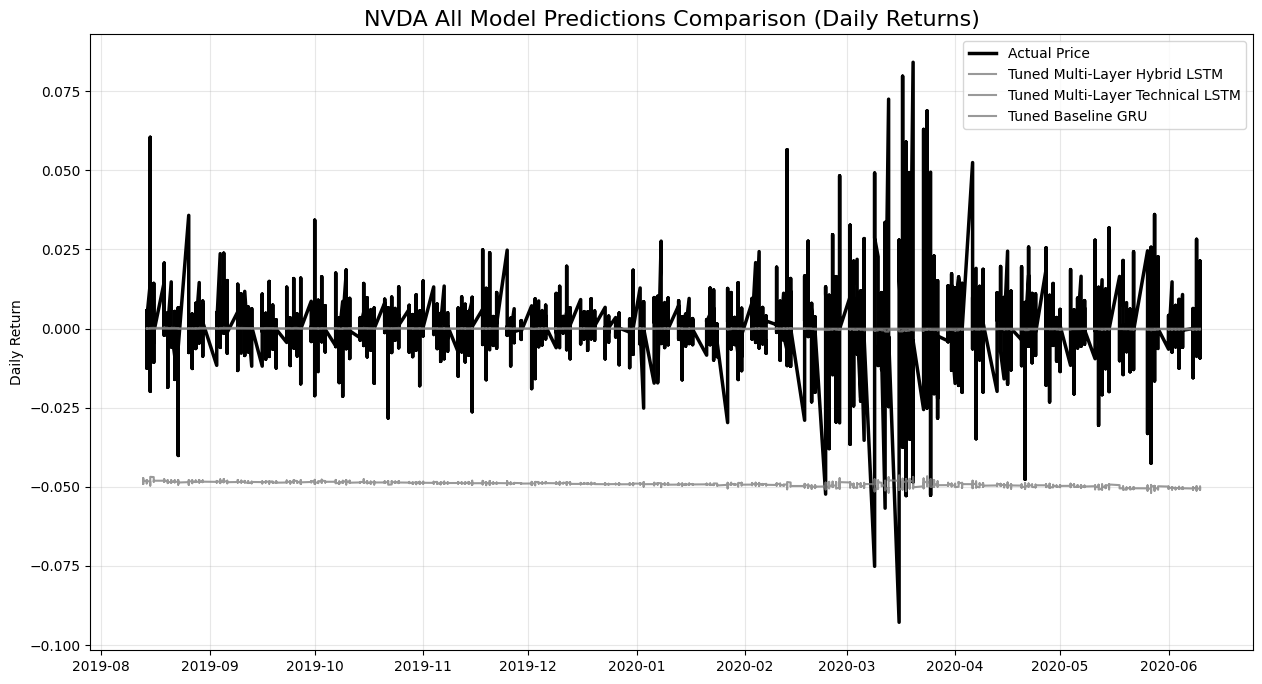

CPU times: user 238 ms, sys: 0 ns, total: 238 ms
Wall time: 482 ms


In [49]:
%%time

# --- 6. Plot Final Comparison of All Major Models ---

# Create a dictionary containing the data for the final plot.
# Each entry needs the date series and the corresponding predicted values.
plot_data = {
    # The 'Actual' values from the longest available dataset (enhanced)
    "Actual": {"dates": test_dates_enh, "values": y_test_enh_scaled},
    # --- Best Models from Each Category for Clarity ---
    # You can uncomment more models, but the plot may become cluttered.
    # We'll start by plotting the best-ranked models.
    # Best Overall Model (Example: replace with your actual winner)
    "Tuned Multi-Layer Hybrid LSTM": {
        "dates": test_dates_enh,
        "values": multi_preds_scaled_enh,
    },
    # Best Technical Model (Example)
    "Tuned Multi-Layer Technical LSTM": {
        "dates": test_dates_tech,
        "values": multi_preds_scaled_tech,
    },
    # Best Baseline Model (Example)
    "Tuned Baseline GRU": {"dates": test_dates_base, "values": base_gru_preds_scaled},
    # Classical Benchmark
    # "ARIMA": {"dates": test_dates_arima, "values": arima_predictions_np},
}

# --- Optional: Uncomment the block below to plot ALL models ---
# plot_data = {
#     "Actual": {"dates": test_dates_enh, "values": y_test_enh_scaled},
#     "Baseline LSTM": {"dates": test_dates_base, "values": base_preds_scaled},
#     "Technical LSTM": {"dates": test_dates_tech, "values": tech_preds_scaled},
#     "Hybrid LSTM": {"dates": test_dates_enh, "values": enh_preds_scaled},
#     "Baseline Multi-Layer LSTM": {"dates": test_dates_base, "values": multi_preds_scaled_base},
#     "Technical Multi-Layer LSTM": {"dates": test_dates_tech, "values": multi_preds_scaled_tech},
#     "Hybrid Multi-Layer LSTM": {"dates": test_dates_enh, "values": multi_preds_scaled_enh},
#     "Baseline GRU": {"dates": test_dates_base, "values": base_gru_preds_scaled},
#     "Technical GRU": {"dates": test_dates_tech, "values": tech_gru_preds_scaled},
#     "Hybrid GRU": {"dates": test_dates_enh, "values": enh_gru_preds_scaled},
#     "Baseline SVM": {"dates": test_dates_base, "values": base_svm_preds_scaled},
#     "Technical SVM": {"dates": test_dates_tech, "values": tech_svm_preds_scaled},
#     "Hybrid SVM": {"dates": test_dates_enh, "values": enh_svm_preds_scaled},
#     "ARIMA": {"dates": test_dates_arima, "values": arima_predictions_np},
# }

# Call the plotting function from your utils file
ut.plot_final_comparison(
    plot_data,
    cfg.STOCK_SYMBOL,
    f"{cfg.STOCK_SYMBOL} All Model Predictions Comparison (Daily Returns)",
)

In [50]:
try:
    end_time = time.time()
    total_time = end_time - start_time
    print(f"--- Total Notebook Runtime: {ut.format_runtime(total_time)} seconds ---")
except NameError:
    print("⚠️ --- Timer could not be stopped because 'start_time' was not defined.")

--- Total Notebook Runtime: 6 minutes 38.99 seconds seconds ---
